In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Colaborative Filtering

### Creating Dataloaders

In [2]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [3]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user', 'movie', 'rating', 'timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie', 'title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [5]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [6]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs = 64)
# user column is already specified in the df; will be autodetected
dls.show_batch()

,user,title,rating
0,488,Three Wishes (1995),4
1,468,Cape Fear (1991),4
2,339,Pulp Fiction (1994),5
3,487,Air Force One (1997),5
4,230,Some Folks Call It a Sling Blade (1993),5
5,83,Richie Rich (1994),3
6,514,Ed Wood (1994),4
7,62,Rosencrantz and Guildenstern Are Dead (1990),4
8,653,"Road to Wellville, The (1994)",1
9,308,"Empire Strikes Back, The (1980)",4


In [7]:
n_users= len(dls.classes['user'])
n_movies= len(dls.classes['title'])
n_factors= 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [8]:
user_factors.shape, movie_factors.shape

(torch.Size([944, 5]), torch.Size([1665, 5]))

In [9]:
# To calc the result of particular movie and user combination
# we have to to look up the index of the movie in our movie latent factor matrix
# similarly, we have to do it for user
# Getting user 3 latent factors
one_hot_3 = one_hot(3, n_users).float() # Creating one hot encoding vector
print(one_hot_3.shape)
user_factors.T @ one_hot_3

torch.Size([944])


tensor([-1.0532,  0.3886,  0.9772, -0.2850,  0.5977])

In [10]:
user_factors[3] # It gives us the same vector as the one at index3 in the matrix

tensor([-1.0532,  0.3886,  0.9772, -0.2850,  0.5977])

In [11]:
# Trying with multiple users
one_hot_0= one_hot(0, n_users).float()
one_hot_1= one_hot(1, n_users).float()
one_hot_2= one_hot(2, n_users).float()
index_012 = torch.stack((one_hot_0, one_hot_1, one_hot_2))
index_012, index_012.shape

(tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]]),
 torch.Size([3, 944]))

In [12]:
index_012 @ user_factors

tensor([[-1.2001, -1.5902, -0.2054, -1.9588, -0.4297],
        [ 0.0075, -0.1488, -0.7763, -0.1944,  0.2528],
        [ 0.0198,  2.4172,  0.1497,  0.2591,  0.1722]])

- This would be a perfectly acceptable way to build models using this kind of architecture, except that it would use a lot more memory and time than necessary.
- we know that there is no real underlying reason to store the one-hot-encoded vector, or to search through it to find the occurrence of the number one—we should just be able to index into an array directly with an integer. 
>  Therefore, most deep learning libraries, including PyTorch, include a special layer that does just this; it indexes into a vector using an integer, but has its derivative calculated in such a way that it is identical to what it would have been if it had done a matrix multiplication with a one-hot-encoded vector. This is called an embedding.

In [13]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
    
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users*movies).sum(dim=1)

In [14]:
x, y = dls.one_batch()
x.shape, x, y

(torch.Size([64, 2]),
 tensor([[ 269,  554],
         [ 533,  861],
         [ 307, 1214],
         [ 800, 1399],
         [ 239, 1566],
         [ 621,  499],
         [ 540,  499],
         [   1,  304],
         [ 727,  391],
         [ 642,  255],
         [ 387,  407],
         [ 514,   90],
         [ 130, 1022],
         [ 441,  929],
         [ 295,  235],
         [ 499,  400],
         [ 453, 1343],
         [ 707, 1218],
         [ 138, 1033],
         [  26,   60],
         [ 303,  868],
         [ 524,  971],
         [ 820, 1370],
         [ 854,  294],
         [ 327, 1159],
         [ 189, 1485],
         [ 630, 1235],
         [ 328,  518],
         [ 255,   92],
         [ 940, 1133],
         [ 430,  774],
         [ 455, 1555],
         [ 883,  185],
         [ 480,  777],
         [  24,  779],
         [ 664,  529],
         [ 144,  475],
         [ 346,  748],
         [ 819,  334],
         [  57, 1525],
         [ 537,  348],
         [ 741,  263],
         [ 4

In [15]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [16]:
model.user_factors, model.user_factors

(Embedding(944, 50), Embedding(944, 50))

In [17]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.374248,1.285199,00:11
1,1.102865,1.077336,00:11
2,0.998387,0.965022,00:11
3,0.855767,0.874870,00:10
4,0.792668,0.861331,00:10


### Adding Non Linearity
Adding prediction range limiter

In [18]:
# Improving model by adding non linearity 
# so that the prediction range is in the desired range
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
    def forward(self, x):
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])
        return sigmoid_range((users*movies).sum(dim=1), *self.y_range)

In [19]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func = MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.006023,0.973864,00:11
1,0.859433,0.879696,00:11
2,0.676255,0.846476,00:10
3,0.455348,0.851379,00:11
4,0.368183,0.856599,00:10


### Adding Bias Factor
- Adding Bias so that we can adjust the missing piece which is that some users are just more positive or negative in their recommendations than others, and some movies are just plain better or worse than others
- We don't have any way of representing it in the dot product table.
> We can represent that how much the action it contains, is it sci-fi, is it old... but there's no way to represent that movie is generally percieved ie, liked/disliked by everyone
Similarly, whether user prefers watching movies and liking them or not.

In [20]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 55)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
    def forward(self, x):
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])
        res = (users*movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [21]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,6.926336,5.949299,00:11
1,1.871472,2.264665,00:11
2,1.337353,1.616179,00:11
3,0.924596,1.346371,00:11
4,0.785889,1.271278,00:11


## Preventing Overfitting
### Weight Decay or L2 Regularisation
- Adding sum of the square of the weight to the loss function
- To penalize the model for carrying larger weights
- Resulting in less sparse network and pushes the prediction towards the underfitting

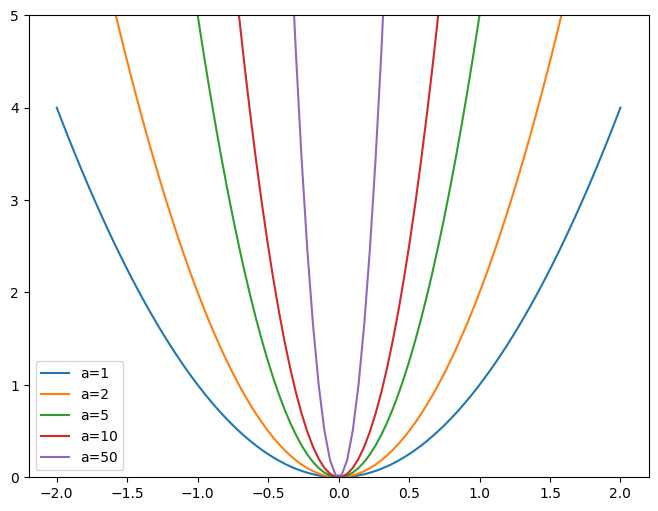

In [22]:
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();
# This shows that having higher weights gives the model better flexibility
# and allows it to overfit 

- letting our model learn high parameters might cause it to fit all the data points in the training set with an overcomplex function that has very sharp changes, which will lead to overfitting.
- Limiting our weights from growing too much is going to hinder the training of the model, but it will yield a state where it generalizes better.
- weight decay (or just wd) is a parameter that controls that sum of squares we add to our loss (assuming parameters is a tensor of all parameters)

> loss_with_wd = loss + wd * (parameters**2).sum()

or we can directly modify the parameters grad with the derivative of the L2 regularization calculation

> parameters.grad += wd * 2 * x

In [23]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.05)

epoch,train_loss,valid_loss,time
0,6.859627,6.393566,00:11
1,2.003508,2.462308,00:10
2,1.576877,1.840055,00:10
3,1.042653,1.504336,00:09
4,0.915589,1.421461,00:10


## Creating our own embedding

In [24]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))
        
L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [25]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1,3, bias = False)
        
t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[0.7459],
        [0.4887],
        [0.7716]], requires_grad=True)]

In [26]:
print(t.a.weight)
type(t.a.weight)

Parameter containing:
tensor([[0.7459],
        [0.4887],
        [0.7716]], requires_grad=True)


torch.nn.parameter.Parameter

In [27]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))
create_params((2,3))

Parameter containing:
tensor([[ 0.0074, -0.0077,  0.0277],
        [ 0.0014,  0.0111,  0.0118]], requires_grad=True)

In [28]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [29]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.957760,0.932764,00:09
1,0.855884,0.856796,00:10
2,0.727455,0.815070,00:10
3,0.597791,0.801845,00:11
4,0.475421,0.803201,00:11


## Interpreting Embeddings and Biases

In [30]:
# Uncovering the parameters that model discovered
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Cable Guy, The (1996)',
 'Robocop 3 (1993)',
 'Children of the Corn: The Gathering (1996)',
 'Island of Dr. Moreau, The (1996)']

- it's saying is that for each of these movies, even when a user is very well matched to its latent factors (which, as we will see in a moment, tend to represent things like level of action, age of movie, and so forth), they still generally don't like it

In [31]:
# Similarly we are getting the top liked movies
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Star Wars (1977)',
 'Usual Suspects, The (1995)',
 'L.A. Confidential (1997)']

### PCA (Principal Component Analysis)
Technique to interpret all the factors in the embedding matrix.

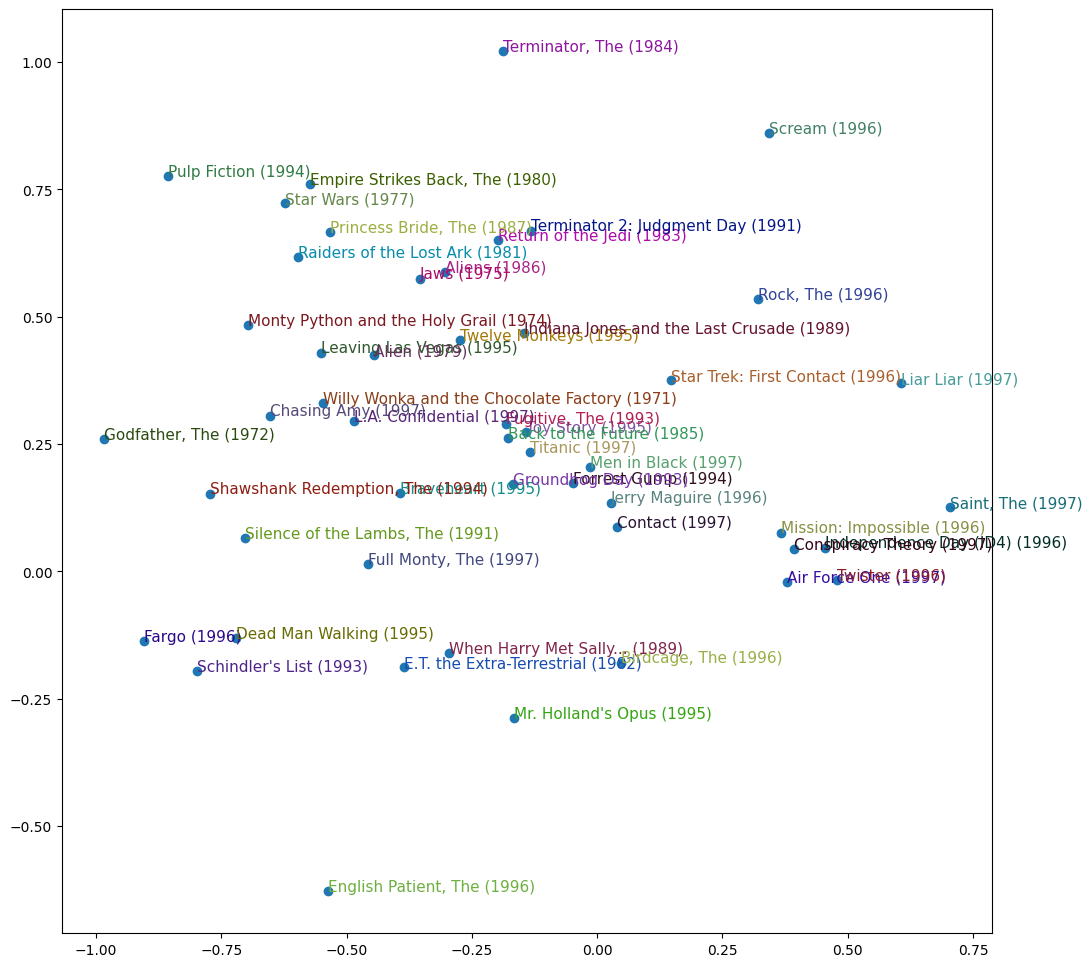

In [32]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X,Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x, y, i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

We can see here that the model seems to have discovered a concept of classic versus pop culture movies, or perhaps it is critically acclaimed that is represented here.

# Using Fastai.colab

In [33]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.958841,0.936974,00:12
1,0.851947,0.859617,00:11
2,0.739755,0.814046,00:12
3,0.607143,0.805089,00:12
4,0.493639,0.806216,00:12


In [34]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [35]:
learn.model.i_weight

Embedding(1665, 50)

In [36]:
# Analyzing the parameter
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Star Wars (1977)',
 'L.A. Confidential (1997)',
 'Rear Window (1954)',
 'Shawshank Redemption, The (1994)']

## Embedding Distance
Distance between two points in 2D plane $\sqrt{x^{2}+y^{2}}$
For distance between two points in 50 Dimmension we have to add squares of all 50 of the coordinate distances.

- If two movies are identical, then there embedding vectors would also have to be nearly identical, because users that would like them would also be nearly the same.
- There is a more general idea: Movie similarity can be defined by the similarity of users that like those movies.
- And that directly means that distance between two movie movies' embedding vectors can define that similarity.

In [37]:
# finding the movie closest to the 'Silence of the lambs'
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Laura (1944)'

# Deep Learning for Collaboratice Filtering
To turn our architechture into DL Model,
- the fist step is to take the results of embedding lookup and concatenate those activation together. This gives us matrix which we can pass in linear layers and nonlinearites in the usual way.

- Since we'll be concatenating the embedding, rather than taking their dot product. The two embedding matrices can have different size (different num of latent factors).



In [38]:
# using fastai function to get the recommended embedding size
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [39]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0, 5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
                    nn.Linear(user_sz[1] + item_sz[1], n_act),  # 74 + 102 = 176 Input cells
                    nn.ReLU(),
                    nn.Linear(n_act,1)
                )
        self.y_range = y_range
    def forward(self, x):
        # Getting the userembedding and itemembedding using the indexing element x
        embs = self.user_factors(x[:,0]), self.item_factors(x[:, 1]) 
        # Concatenating the embedding so that these would be passed into Neural Network as Input
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)
    

In [40]:
model = CollabNN(*embs)

In [41]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.934232,0.925283,00:14
1,0.887448,0.894437,00:15
2,0.862501,0.867222,00:14
3,0.802352,0.848064,00:12
4,0.778882,0.852651,00:12


In [42]:
learn.model.item_factors(torch.tensor([1]))
# Embedding are not subscriptable with list or tensor like indices
# Call the embedding with the list or tensor to get the embedding

tensor([[-0.1774,  0.1784, -0.1135, -0.1578,  0.1491,  0.0640,  0.1013,  0.0577,
         -0.1727,  0.2161, -0.2124, -0.1908,  0.2294,  0.0459, -0.1792,  0.2050,
         -0.2511, -0.2062, -0.1516, -0.2307, -0.1611,  0.2602,  0.2640,  0.2306,
          0.2035, -0.2055,  0.2156, -0.2432, -0.1841,  0.1660,  0.2294, -0.1780,
         -0.2540, -0.1765,  0.1773,  0.1772, -0.2410, -0.2654, -0.2505, -0.1796,
          0.1794,  0.2165, -0.2308, -0.1921, -0.2442, -0.1927, -0.2641,  0.0380,
          0.2341, -0.0734, -0.2137, -0.2552, -0.2010, -0.0991,  0.1639,  0.1178,
         -0.2212,  0.2317,  0.2379, -0.2100, -0.2429,  0.2035,  0.2464,  0.2556,
         -0.1489,  0.1916, -0.2432,  0.2310,  0.1276, -0.2332, -0.2416,  0.1087,
          0.1959,  0.2527,  0.1745, -0.2068,  0.2299,  0.2280,  0.2733,  0.2661,
         -0.2546,  0.1142,  0.2316, -0.2526, -0.2617, -0.2416, -0.2302, -0.2179,
         -0.2209, -0.0194,  0.2453, -0.2342,  0.1563,  0.1827,  0.2488,  0.0199,
          0.1192, -0.2383, -

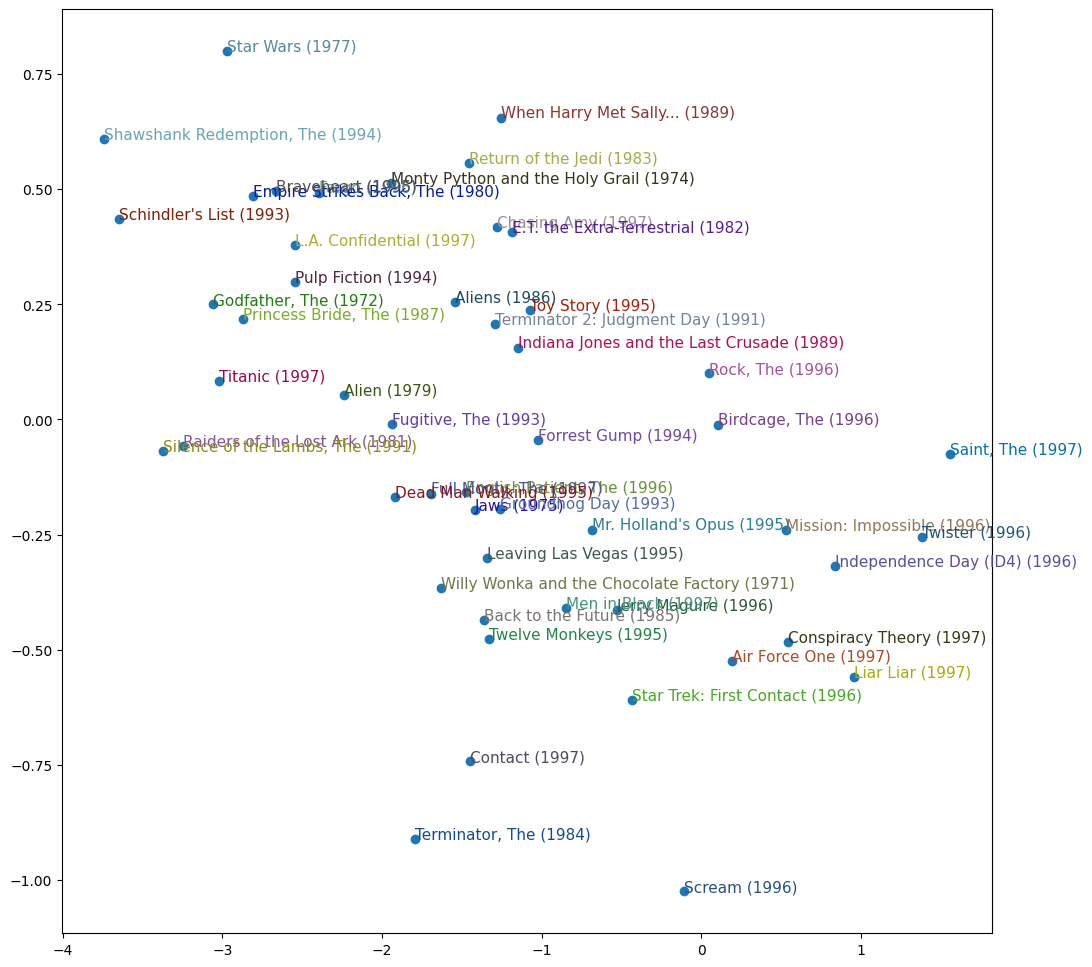

In [43]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.item_factors(top_idxs).cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

### Using NN in fastai.collab

In [44]:
#  Using two hidden layers of 100 and 50 cells sizes respectively
learn = collab_learner(dls, use_nn = True, y_range=(0,5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.994823,0.960150,00:14
1,0.915753,0.898074,00:15
2,0.895986,0.861658,00:14
3,0.811543,0.838262,00:15
4,0.751256,0.838794,00:15
